# Lab 4 - exploring the class datasets with IPython Notebook

## Crime Dataset
The city of San Francisco released an interesting dataset that lists all crimes committed in the city since 2003, as reported by SFPD. The dataset is freely available on the web at: https://data.sfgov.org/Public-Safety/SFPD-Incidents-from-1-January-2003/tmnf-yvry

We have pre-loaded this "crime event" dataset into HDFS. It's a single file called "sf_crimes.csv" under folder "crime_report".

First, as usual, setup a Spark Context, but since we are working with larger datasets this time -- configure Spark to create 15 executors with 2GB for executor memory

In [1]:
# Set up Spark Context
from pyspark import SparkContext, SparkConf

SparkContext.setSystemProperty('spark.executor.memory', '2g')
conf = SparkConf()
conf.set('spark.executor.instances', 15)
sc = SparkContext('yarn-client', 'Spark-lab4', conf=conf)

Write a Spark program that reads this CSV file into an RDD. Each item in this RDD is a list of all the field values for this line. 

A few notes:
1. The file's first row includes the column names, which are not values, so you may want to ignore this first line. Think about a simple way to filter that line out.
2. Some field values include commas inside quotes, so you have to deal with this appropriately. Look at Python's CSV package (https://docs.python.org/2/library/csv.html) for a simple solution, but bear in mind that csv.reader returns an object that might not be serializable by PySpark, so you'll have to use Python's next() to iterate over it inside your map() function.

Print the total number of crime events in the dataset

In [2]:
from csv import reader
lines = sc.textFile("crime_report/sf_crimes.csv") \
          .filter(lambda line: line[:2]!='In')
crimes = lines.map(lambda line: [x.strip('"') for x in next(reader([line]))])
crimes.cache()
print "number of crimes reported = ", crimes.count()

number of crimes reported =  1750133


Now print 5 example rows from the RDD, using Pandas.
1. Use pd.DataFrame() to convert the first 5 elements of the RDD into a pandas DataFrame
2. Column names are: id, category, description, dayofweek, date, time, district, resolution, address, x, y, location, pdid

In [3]:
import pandas as pd
df = pd.DataFrame(crimes.take(5), \
                  columns=['ID','category','description','dayofweek','date','time', \
                           'district','resolution','address','x','y','location','pdid'])                  
df

,ID,category,description,dayofweek,date,time,district,resolution,address,x,y,location,pdid
0,150331521,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Wednesday,04/22/2015,18:00,BAYVIEW,NONE,2000 Block of EVANS AV,-122.396315619126,37.7478113603031,"(37.7478113603031, -122.396315619126)",15033152106304
1,150341605,ASSAULT,ATTEMPTED SIMPLE ASSAULT,Sunday,04/19/2015,12:15,CENTRAL,NONE,800 Block of WASHINGTON ST,-122.40672716771,37.7950566945259,"(37.7950566945259, -122.40672716771)",15034160504114
2,150341605,ASSAULT,THREATS AGAINST LIFE,Sunday,04/19/2015,12:15,CENTRAL,NONE,800 Block of WASHINGTON ST,-122.40672716771,37.7950566945259,"(37.7950566945259, -122.40672716771)",15034160519057
3,150341605,OTHER OFFENSES,CRUELTY TO ANIMALS,Sunday,04/19/2015,12:15,CENTRAL,NONE,800 Block of WASHINGTON ST,-122.40672716771,37.7950566945259,"(37.7950566945259, -122.40672716771)",15034160528010
4,150341702,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Sunday,04/19/2015,12:03,MISSION,EXCEPTIONAL CLEARANCE,1100 Block of SOUTH VAN NESS AV,-122.416557578218,37.7547485110398,"(37.7547485110398, -122.416557578218)",15034170264020


The "category" field has multiple different values it may contain. 
Write a Spark program that counts the number of crimes of each category.

In [4]:
rdd1 = crimes.map(lambda x: (x[1],1)).reduceByKey(lambda x,y: x+y)
df1 = pd.DataFrame(rdd1.collect(), columns=['category', 'count']) \
        .set_index('category').sort(columns='count', ascending=False).ix[:20]
df1

,count
category,
LARCENY/THEFT,348523
OTHER OFFENSES,251180
NON-CRIMINAL,183911
ASSAULT,153485
DRUG/NARCOTIC,107653
VEHICLE THEFT,107112
VANDALISM,89282
WARRANTS,83919
BURGLARY,73539


Use Panda's plot function to display the count per category as a bar chart

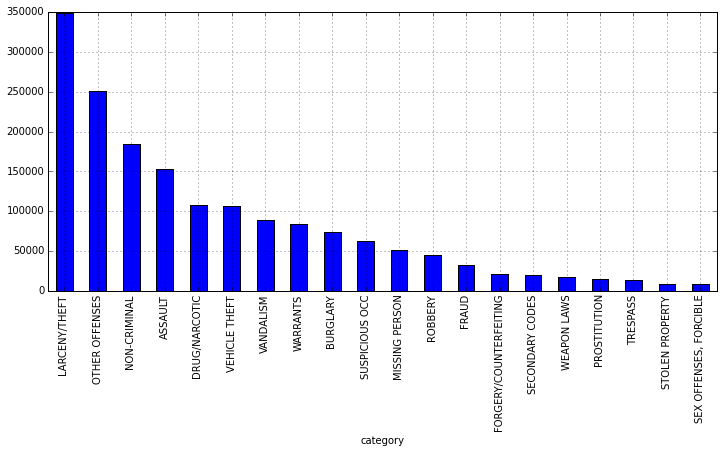

In [5]:
df1.plot(kind='bar', legend=False, figsize=(12,5))

Now write a program that counts the number of crimes per district

In [6]:
rdd2 = crimes.map(lambda x: (x[6],1)).reduceByKey(lambda x,y: x+y)
df2 = pd.DataFrame(rdd2.collect(), columns=['district', 'count']) \
        .set_index('district').sort(columns='count', ascending=False)
df2

,count
district,
SOUTHERN,312530
MISSION,238929
NORTHERN,210807
BAYVIEW,177955
CENTRAL,170113
TENDERLOIN,162724
INGLESIDE,157816
TARAVAL,131149
PARK,98712


Use Panda's plot function to display this data in a bar chart

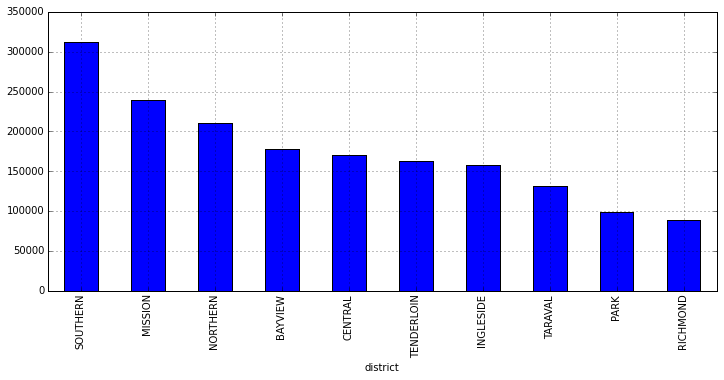

In [7]:
df2.plot(kind='bar', legend=False, figsize=(12,5))

## Weather Dataset

We also have a weather dataset that includes various measurements from weather stations around the country. This dataset is loaded into HDFS under the "weather" folder.

Write a Spark program that loads the weather data for 2013 (under the path "weather/2013.csv") into an RDD.
Note that the file has comma-separated records, each with 8 fields, but we only care about the first 4 (in order):
- station name
- date
- metric type
- value

Use pandas pd.DataFrame(...) function to translate the result into a Pandas dataframe that includes the first 5 elements in this RDD and print the resulting Pandas dataframe.

In [8]:
import pandas as pd

lines = sc.textFile("weather/2013.csv")
weather = lines.map(lambda line: line.split(',')) \
               .map(lambda row: [row[0], row[1], row[2], row[3]])  # schema: station, date, metric type, value
weather.cache()
pd.DataFrame(weather.take(5), columns = ['station', 'date', 'metric', 'value'])

,station,date,metric,value
0,US1FLSL0019,20130101,PRCP,0
1,US1FLSL0019,20130101,SNOW,0
2,US1TXTV0133,20130101,PRCP,30
3,USC00178998,20130101,TMAX,-22
4,USC00178998,20130101,TMIN,-117


Count the number of unique weather stations in this RDD

In [9]:
print weather.map(lambda x: x[0]).distinct().count()

38041


Calculate the number of readings for each metric. Which are the top-10 most popular metrics?

In [10]:
countPerMetric = weather.map(lambda x: (x[2],1)).reduceByKey(lambda x,y: x+y)
df = pd.DataFrame(countPerMetric.collect(), columns = ['metric', 'count'])
df.set_index('metric').sort(columns='count', ascending=False).ix[:10]

,count
metric,
PRCP,9610910
SNOW,4347479
TMAX,4218043
TMIN,4217620
SNWD,2403494
TOBS,1934418
AWND,356119
WESD,346821
WSF2,343373


Compute and plot the maximum daily temparature (TMAX) in San Francisco (weather station USW00023272) during the month of December 2013:
* First filter the dataset to the SF weather station and to the TMAX metric
* use map() to generate an RDD with a tuple of: (1) day (2) TMAX value for that day
* Turn the RDD into a Pandas dataframe and print/plot

In [11]:
tmax = weather.filter(lambda x: x[2]=='TMAX').filter(lambda x: x[0]=='USW00023272') \
              .filter(lambda x: x[1][:6]=='201312') \
              .map(lambda x: (int(x[1][6:8]), float(x[3])/10.0*1.8+32))
pdf = pd.DataFrame(tmax.collect(), columns=['day', 'tmax']).set_index('day')
print pdf

      tmax
day       
1    66.92
2    59.00
3    55.04
4    51.08
5    50.00
6    51.08
7    51.08
8    46.04
9    51.08
10   53.06
11   55.94
12   57.92
13   57.92
14   60.98
15   59.00
16   66.92
17   64.04
18   55.94
19   57.92
20   57.92
21   57.92
22   64.04
23   60.98
24   66.02
25   64.94
26   64.94
27   60.98
28   62.96
29   66.02
30   60.98
31   59.00


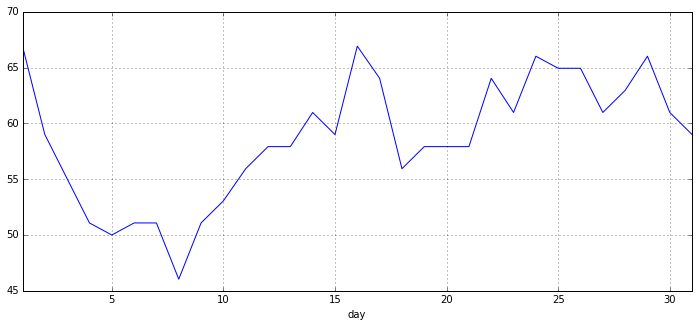

In [12]:
pdf.plot(kind='line', legend=False, figsize=(12,5))